In [1]:
!pip install neptune --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.9/487.9 kB 11.6 MB/s eta 0:00:0000:01


# ***About DataSet****
### **train**
- **apple_pie** -1000 фото
- **cheesecake** -1000 фото
- **chicken_curry** -1000 фото
- **french_fries** -1000 фото
- **fried_rice** -1000 фото
- **hamburger** -1000 фото
- **hot_dog** -1000 фото
- **ice_cream** -1000 фото
- **omellete** -1000 фото
- **pizza** -1000 фото
- **sushi** -1000 фото
#### train size: 11000 фото  
### **test**
- **apple_pie** -100 фото
- **cheesecake** -100 фото
- **chicken_curry** -100 фото
- **french_fries** -100 фото
- **fried_rice** -100 фото
- **hamburger** -100 фото
- **hot_dog** -100 фото
- **ice_cream** -100 фото
- **omellete** -100 фото
- **pizza** -100 фото
- **sushi** -100 фото
#### test size: 1100 фото

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import (
    efficientnet_b0, efficientnet_b1, efficientnet_b2,
    efficientnet_b3,mobilenet_v2,
    resnet18,
    EfficientNet_B0_Weights, EfficientNet_B1_Weights,
    EfficientNet_B2_Weights, EfficientNet_B3_Weights,
    MobileNet_V2_Weights,ResNet18_Weights
)
from sklearn.metrics import f1_score

from tqdm import tqdm
import neptune
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


In [3]:
device=torch.device('cuda')
num_classes = 11


In [4]:
def evaluate(model, dataloader, device, num_classes):
    model.eval()
    accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)
    f1_macro = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)
    f1_weighted = MulticlassF1Score(num_classes=num_classes, average='weighted').to(device)
    
    total_loss = 0.0
    total_samples = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * images.size(0)
            total_samples += labels.size(0)

            preds = outputs.argmax(dim=1)
            accuracy.update(preds, labels)
            f1_macro.update(preds, labels)
            f1_weighted.update(preds, labels)

    avg_loss = total_loss / total_samples
    acc = accuracy.compute().item()
    f1_mac = f1_macro.compute().item()
    f1_w = f1_weighted.compute().item()

    model.train()
    return avg_loss, acc, f1_mac, f1_w  

In [5]:

def train_model(
    model,
    train_loader,
    test_loader,
    train_dataset,
    num_epochs,
    num_classes,      
    optimizer,
    criterion,
    device=None,
    project_name="kulikovka/CNN-models-test",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiNjZjNWE3OS1jMzRlLTQyZjAtYmFiNi04ZGU1ZjY0MDAxNzgifQ=="
):
    model = model.to(device)

    run = neptune.init_run(project=project_name, api_token=api_token)
    run["parameters"] = {
        "epochs": num_epochs,
        "batch_size": train_loader.batch_size,
        "num_classes": num_classes,
        "device": str(device)
    }

    train_losses, train_accs, train_f1s = [], [], []
    test_losses, test_accs, test_f1s = [], [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        f1_train_metric = MulticlassF1Score(num_classes=num_classes, average='weighted').to(device)
        accuracy_train_metric = MulticlassAccuracy(num_classes=num_classes).to(device)

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            accuracy_train_metric.update(preds, labels)
            f1_train_metric.update(preds, labels)

            current_acc = accuracy_train_metric.compute().item()
            pbar.set_postfix({"loss": loss.item(), "acc": f"{100 * current_acc:.1f}%"})

        train_loss = epoch_loss / len(train_dataset)
        train_acc = accuracy_train_metric.compute().item()
        train_f1 = f1_train_metric.compute().item()

        test_loss, test_acc, _, test_f1 = evaluate(model, test_loader, device, num_classes)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_f1s.append(train_f1)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        test_f1s.append(test_f1)

        run["train/loss"].append(train_loss)
        run["train/accuracy"].append(train_acc)
        run["train/f1"].append(train_f1)          
        run["test/loss"].append(test_loss)
        run["test/accuracy"].append(test_acc)
        run["test/f1"].append(test_f1)            
        run["epoch"].append(epoch)

        print(f"Epoch {epoch}: "
              f"Train loss={train_loss:.4f}, Acc={train_acc:.4f}, F1={train_f1:.4f} | "
              f"Test loss={test_loss:.4f}, Acc={test_acc:.4f}, F1={test_f1:.4f}")

    run.stop()
    return {
        "train_loss": train_losses,
        "train_acc": train_accs,
        "train_f1": train_f1s,
        "test_loss": test_losses,
        "test_acc": test_accs,
        "test_f1": test_f1s
    }

In [6]:
def plot_confusion_matrix(model, dataloader, class_names):

    model.eval()
    all_labels = []
    all_preds  = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Предсказанный класс")
    plt.ylabel("Настоящий класс")
    plt.title("Матрица ошибок")
    plt.show()


In [7]:
data_dir = "/kaggle/input/food11/food11"


# ***EfficientNet-B0***

In [8]:
img_size = 224
batch_size = 16
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(img_size + 20),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(f"{data_dir}/train", transform=train_transforms)
test_dataset  = datasets.ImageFolder(f"{data_dir}/test",  transform=test_transforms)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)



In [9]:
num_classes = 11

weights = EfficientNet_B0_Weights.DEFAULT
model_b0 = efficientnet_b0(weights=weights)
model_b0.classifier[1] = nn.Linear(model_b0.classifier[1].in_features, num_classes)
model_b0 = model_b0.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 109MB/s] 


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer= optim.Adam(model_b0.parameters(), lr=1e-4)
num_epochs=10
device=torch.device('cuda')

In [11]:
train_model(model=model_b0,  train_loader=train_loader,
    test_loader=test_loader,
    train_dataset=train_dataset,
    num_epochs=num_epochs,
    num_classes=num_classes,      
    optimizer=optimizer,
    criterion=criterion,
    device=device,
           )

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs-legacy.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/kulikovka/CNN-models-test/e/CNNMOD-27


Epoch 1/10: 100%|██████████| 619/619 [02:57<00:00,  3.48it/s, loss=0.9, acc=66.0%]  


Epoch 1: Train loss=1.1330, Acc=0.6597, F1=0.6591 | Test loss=0.4286, Acc=0.8700, F1=0.8705


Epoch 2/10: 100%|██████████| 619/619 [02:02<00:00,  5.05it/s, loss=0.567, acc=81.9%] 


Epoch 2: Train loss=0.5758, Acc=0.8195, F1=0.8193 | Test loss=0.3319, Acc=0.8945, F1=0.8951


Epoch 3/10: 100%|██████████| 619/619 [02:00<00:00,  5.13it/s, loss=0.589, acc=85.3%] 


Epoch 3: Train loss=0.4656, Acc=0.8531, F1=0.8531 | Test loss=0.3198, Acc=0.9045, F1=0.9049


Epoch 4/10: 100%|██████████| 619/619 [02:01<00:00,  5.08it/s, loss=0.513, acc=88.1%] 


Epoch 4: Train loss=0.3784, Acc=0.8810, F1=0.8809 | Test loss=0.2719, Acc=0.9145, F1=0.9148


Epoch 5/10: 100%|██████████| 619/619 [02:01<00:00,  5.09it/s, loss=0.291, acc=89.7%]  


Epoch 5: Train loss=0.3341, Acc=0.8971, F1=0.8971 | Test loss=0.2792, Acc=0.9100, F1=0.9101


Epoch 6/10: 100%|██████████| 619/619 [02:00<00:00,  5.13it/s, loss=0.371, acc=91.1%] 


Epoch 6: Train loss=0.2839, Acc=0.9108, F1=0.9108 | Test loss=0.2730, Acc=0.9164, F1=0.9165


Epoch 7/10: 100%|██████████| 619/619 [02:01<00:00,  5.08it/s, loss=0.692, acc=91.6%] 


Epoch 7: Train loss=0.2639, Acc=0.9162, F1=0.9161 | Test loss=0.2766, Acc=0.9200, F1=0.9203


Epoch 8/10: 100%|██████████| 619/619 [02:01<00:00,  5.10it/s, loss=0.311, acc=92.9%] 


Epoch 8: Train loss=0.2229, Acc=0.9294, F1=0.9294 | Test loss=0.2888, Acc=0.9173, F1=0.9177


Epoch 9/10: 100%|██████████| 619/619 [01:59<00:00,  5.18it/s, loss=0.242, acc=93.8%]  


Epoch 9: Train loss=0.1963, Acc=0.9383, F1=0.9383 | Test loss=0.3032, Acc=0.9227, F1=0.9229


Epoch 10/10: 100%|██████████| 619/619 [01:58<00:00,  5.22it/s, loss=0.581, acc=94.1%]  


Epoch 10: Train loss=0.1842, Acc=0.9409, F1=0.9409 | Test loss=0.3035, Acc=0.9145, F1=0.9147
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 7 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 7 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/kulikovka/CNN-models-test/e/CNNMOD-27/metadata


{'train_loss': [1.1330409369083365,
  0.5757555487420823,
  0.46564960576067066,
  0.3784063186549177,
  0.33410123018228044,
  0.2838661958427742,
  0.2639241358938843,
  0.22291956863770582,
  0.1963493069329045,
  0.1842270816501343],
 'train_acc': [0.6596969962120056,
  0.8194949626922607,
  0.8531312942504883,
  0.8810100555419922,
  0.8970706462860107,
  0.9108080863952637,
  0.9161616563796997,
  0.929394006729126,
  0.93828284740448,
  0.9409090876579285],
 'train_f1': [0.659140944480896,
  0.8193029165267944,
  0.853129506111145,
  0.880937933921814,
  0.8970617651939392,
  0.9108386039733887,
  0.9161238670349121,
  0.9293734431266785,
  0.9383094906806946,
  0.9408730268478394],
 'test_loss': [0.42858065737919376,
  0.3318849820711396,
  0.3198223905129866,
  0.2719154376468875,
  0.2792059057680043,
  0.2729842310669747,
  0.2765547167035666,
  0.2887665124779398,
  0.30321101371537557,
  0.30351935469291424],
 'test_acc': [0.8700000047683716,
  0.8945454359054565,
  0.9045

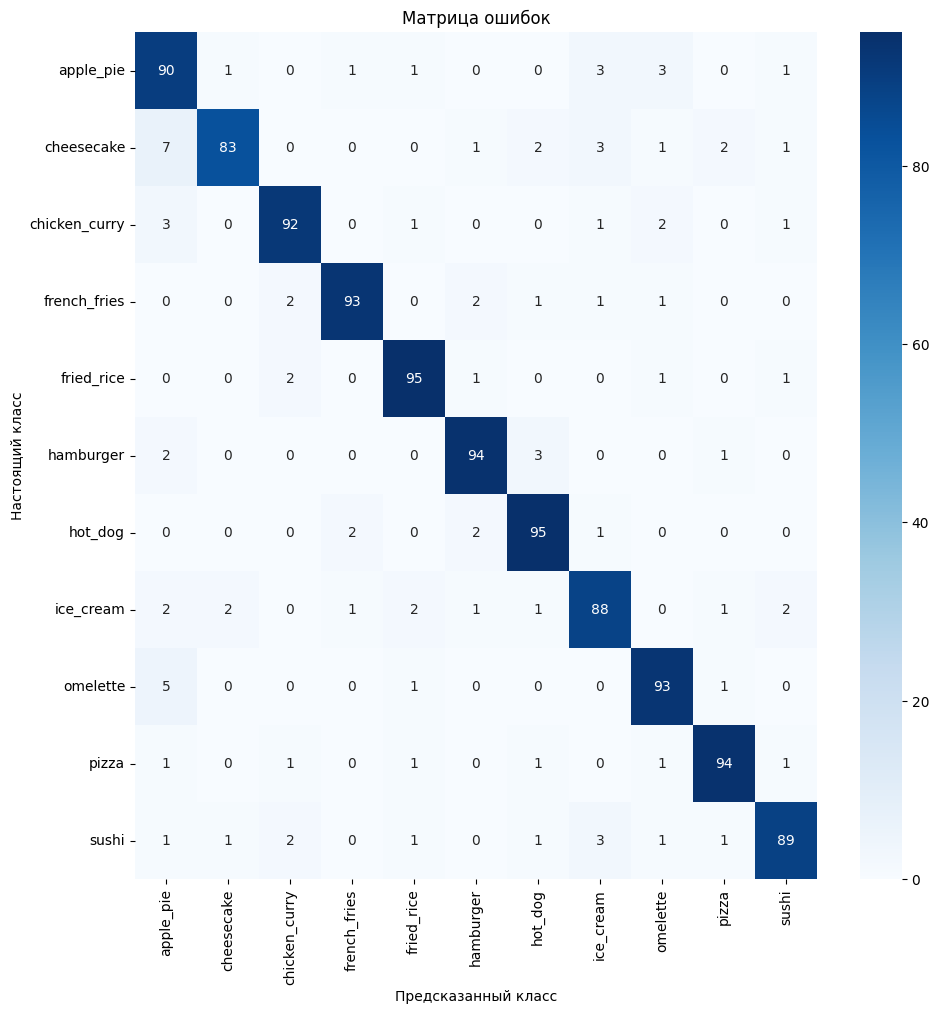

In [12]:
plot_confusion_matrix(model=model_b0, dataloader= test_loader, class_names=test_dataset.classes )

### ***About EfficientNet-B0***
#### **Метрики**
- **train loss=** ***0.1842*** vs **test loss=** ***0.3035***
- **train f1=** ***0.9408*** vs **test f1=** ***0.9147***
- ***model training time: 22:20**
#### **Confusion Matrix Analytics**

- **apple_pie**: 3 раз модель предсказала **ice_cream**.  
- **apple_pie**: 3 раз модель предсказала **omelette**.  
- **cheesecake**: 7 раз модель предсказала **apple_pie**.  
- **cheesecake**: 3 раз модель предсказала **ice_cream**.  
- **cheesecake**: 2 раза модель предсказала **hot_dog**.  
- **cheesecake**: 2 раза модель предсказала **pizza**.  
- **chicken_curry**: 3 раз модель предсказала **apple_pie**.  
- **chicken_curry**: 2 раза модель предсказала **omelette**.  
- **french_fries**: 2 раза модель предсказала **chicken_curry**.  
- **french_fries**: 2 раза модель предсказала **hamburger**.  
- **fried_rice**: 2 раза модель предсказала **chicken_curry**.  
- **hamburger**: 3 раз модель предсказала **hot_dog**.  
- **hamburger**: 2 раза модель предсказала **apple_pie**.  
- **hot_dog**: 2 раза модель предсказала **french_fries**.  
- **hot_dog**: 2 раза модель предсказала **hamburger**.  
- **ice_cream**: 2 раза модель предсказала **apple_pie**.  
- **ice_cream**: 2 раза модель предсказала **cheesecake**.  
- **ice_cream**: 2 раза модель предсказала **fried_rice**.  
- **ice_cream**: 2 раза модель предсказала **sushi**.  
- **omelette**: 5 раз модель предсказала **apple_pie**.  
- **sushi**: 3 раз модель предсказала **ice_cream**.  
- **sushi**: 2 раза модель предсказала **chicken_curry**. 

# ***EfficientNet-B1***

In [13]:
weights = EfficientNet_B1_Weights.DEFAULT
model_b1 = efficientnet_b1(weights=weights)
model_b1.classifier[1] = nn.Linear(model_b1.classifier[1].in_features, num_classes)
model_b1 = model_b1.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 146MB/s] 


In [14]:
img_size = 240
batch_size = 16
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(img_size + 20),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(f"{data_dir}/train", transform=train_transforms)
test_dataset  = datasets.ImageFolder(f"{data_dir}/test", transform=test_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer= optim.Adam(model_b1.parameters(), lr=5e-5)
num_epochs=10


In [16]:
train_model(model=model_b1,  train_loader=train_loader,
    test_loader=test_loader,
    train_dataset=train_dataset,
    num_epochs=num_epochs,
    num_classes=num_classes,      
    optimizer=optimizer,
    criterion=criterion,
    device=device,
           )

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/kulikovka/CNN-models-test/e/CNNMOD-28


Epoch 1/10: 100%|██████████| 619/619 [02:35<00:00,  3.97it/s, loss=1.15, acc=60.7%] 


Epoch 1: Train loss=1.3619, Acc=0.6075, F1=0.6053 | Test loss=0.5928, Acc=0.8345, F1=0.8347


Epoch 2/10: 100%|██████████| 619/619 [02:35<00:00,  3.97it/s, loss=0.685, acc=80.6%]


Epoch 2: Train loss=0.6380, Acc=0.8058, F1=0.8057 | Test loss=0.4382, Acc=0.8745, F1=0.8757


Epoch 3/10: 100%|██████████| 619/619 [02:36<00:00,  3.94it/s, loss=0.544, acc=84.5%] 


Epoch 3: Train loss=0.4982, Acc=0.8451, F1=0.8450 | Test loss=0.3519, Acc=0.8964, F1=0.8975


Epoch 4/10: 100%|██████████| 619/619 [02:39<00:00,  3.88it/s, loss=0.494, acc=86.5%] 


Epoch 4: Train loss=0.4411, Acc=0.8645, F1=0.8646 | Test loss=0.3105, Acc=0.9091, F1=0.9094


Epoch 5/10: 100%|██████████| 619/619 [02:38<00:00,  3.90it/s, loss=0.457, acc=88.3%] 


Epoch 5: Train loss=0.3818, Acc=0.8833, F1=0.8833 | Test loss=0.3022, Acc=0.9027, F1=0.9031


Epoch 6/10: 100%|██████████| 619/619 [02:37<00:00,  3.94it/s, loss=1.1, acc=89.1%]   


Epoch 6: Train loss=0.3538, Acc=0.8906, F1=0.8907 | Test loss=0.2644, Acc=0.9145, F1=0.9148


Epoch 7/10: 100%|██████████| 619/619 [02:37<00:00,  3.94it/s, loss=0.273, acc=90.4%] 


Epoch 7: Train loss=0.3003, Acc=0.9036, F1=0.9037 | Test loss=0.2810, Acc=0.9173, F1=0.9178


Epoch 8/10: 100%|██████████| 619/619 [02:38<00:00,  3.92it/s, loss=0.0903, acc=91.0%]


Epoch 8: Train loss=0.2780, Acc=0.9097, F1=0.9097 | Test loss=0.2475, Acc=0.9218, F1=0.9225


Epoch 9/10: 100%|██████████| 619/619 [02:37<00:00,  3.93it/s, loss=0.38, acc=92.1%]  


Epoch 9: Train loss=0.2520, Acc=0.9213, F1=0.9213 | Test loss=0.2467, Acc=0.9291, F1=0.9292


Epoch 10/10: 100%|██████████| 619/619 [02:37<00:00,  3.92it/s, loss=0.348, acc=92.9%] 


Epoch 10: Train loss=0.2285, Acc=0.9288, F1=0.9288 | Test loss=0.2513, Acc=0.9227, F1=0.9230
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 7 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 7 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/kulikovka/CNN-models-test/e/CNNMOD-28/metadata


{'train_loss': [1.3618834826922175,
  0.6379607483594104,
  0.49819590060397834,
  0.4410662885868188,
  0.38184911403993166,
  0.353795522337008,
  0.3003269690124675,
  0.27796666384345353,
  0.25196107359847636,
  0.2284712722235256],
 'train_acc': [0.6074747443199158,
  0.8057575821876526,
  0.8450505137443542,
  0.8645454049110413,
  0.8833333253860474,
  0.8906060457229614,
  0.9036363959312439,
  0.9096969962120056,
  0.9213131070137024,
  0.9287879467010498],
 'train_f1': [0.605297863483429,
  0.8057326078414917,
  0.8450202345848083,
  0.8645528554916382,
  0.883282482624054,
  0.8906515836715698,
  0.9036651849746704,
  0.9097163677215576,
  0.9213123321533203,
  0.9288347959518433],
 'test_loss': [0.5927922756021673,
  0.4381558441032063,
  0.3518945939432491,
  0.3105329297347502,
  0.3022465247999538,
  0.26441998584703963,
  0.28101414712992584,
  0.24750830441713334,
  0.2466900674592365,
  0.25126413889906624],
 'test_acc': [0.8345454335212708,
  0.8745453953742981,
  0

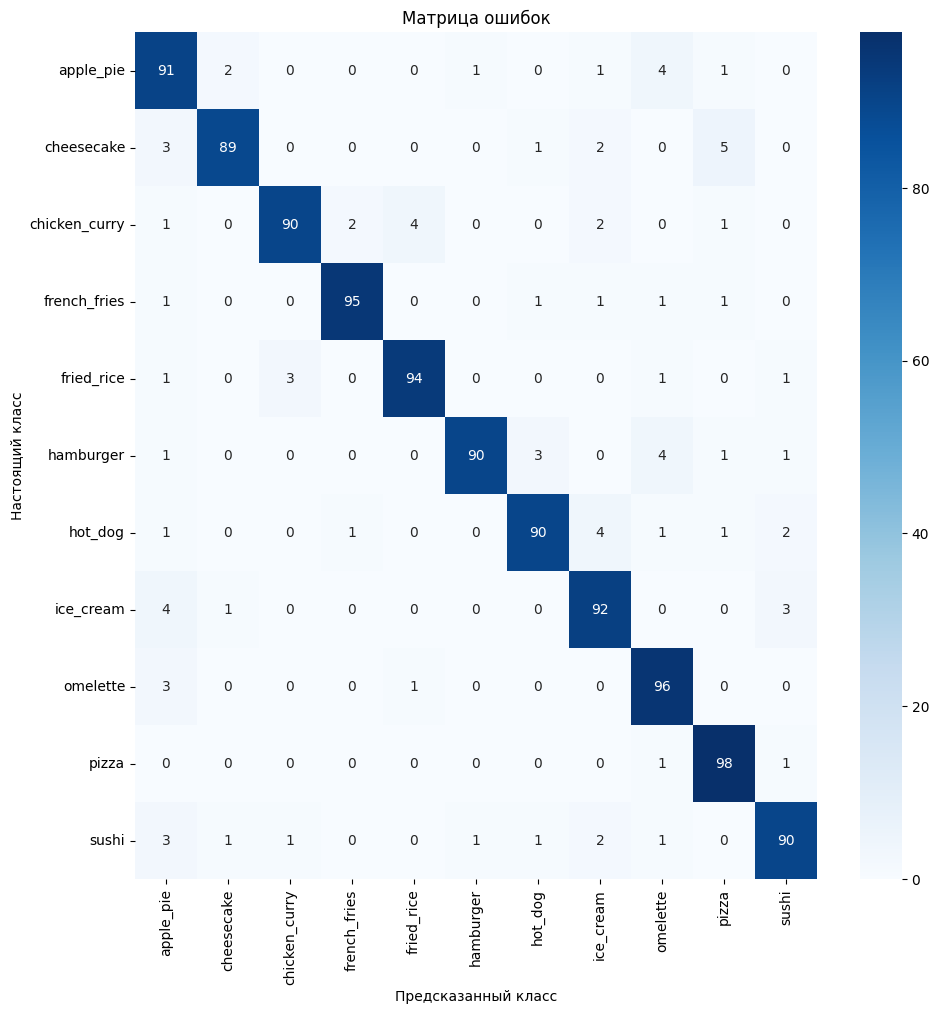

In [17]:
plot_confusion_matrix(model=model_b1, dataloader= test_loader, class_names=test_dataset.classes )

### ***About EfficientNet-B1***
#### **Метрики**
- **train loss=** ***0.2284*** vs **test loss=** ***0.2512***
- **train f1=** ***0.9288*** vs **test f1=** ***0.9230***
- **model training time: 27:32**
#### **Confusion Matrix Analytics**

- **apple_pie**: 4 раз модель предсказала **omelette**.  
- **apple_pie**: 2 раза модель предсказала **cheesecake**.  
- **cheesecake**: 5 раз модель предсказала **pizza**.  
- **cheesecake**: 3 раз модель предсказала **apple_pie**.  
- **cheesecake**: 2 раза модель предсказала **ice_cream**.  
- **chicken_curry**: 4 раз модель предсказала **fried_rice**.  
- **chicken_curry**: 2 раза модель предсказала **french_fries**.  
- **chicken_curry**: 2 раза модель предсказала **ice_cream**.  
- **fried_rice**: 3 раз модель предсказала **chicken_curry**.  
- **hamburger**: 4 раз модель предсказала **omelette**.  
- **hamburger**: 3 раз модель предсказала **hot_dog**.  
- **hot_dog**: 4 раз модель предсказала **ice_cream**.  
- **hot_dog**: 2 раза модель предсказала **sushi**.  
- **ice_cream**: 4 раз модель предсказала **apple_pie**.  
- **ice_cream**: 3 раз модель предсказала **sushi**.  
- **omelette**: 3 раз модель предсказала **apple_pie**.  
- **sushi**: 3 раз модель предсказала **apple_pie**.  
- **sushi**: 2 раза модель предсказала **ice_cream**.  


# ***EfficientNet-B2***

In [18]:
weights = EfficientNet_B2_Weights.DEFAULT
model_b2 = efficientnet_b2(weights=weights)
model_b2.classifier[1] = nn.Linear(model_b2.classifier[1].in_features, num_classes)
model_b2 = model_b2.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 155MB/s] 


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_b2.parameters(), lr=2e-5)
num_epochs=10


In [20]:
img_size = 260
batch_size = 16
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(img_size + 20),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(f"{data_dir}/train", transform=train_transforms)
test_dataset  = datasets.ImageFolder(f"{data_dir}/test",  transform=test_transforms)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [21]:
train_model(model=model_b2,  train_loader=train_loader,
    test_loader=test_loader,
    train_dataset=train_dataset,
    num_epochs=num_epochs,
    num_classes=num_classes,      
    optimizer=optimizer,
    criterion=criterion,
    device=device,
           )

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/kulikovka/CNN-models-test/e/CNNMOD-29


Epoch 1/10: 100%|██████████| 619/619 [03:11<00:00,  3.23it/s, loss=0.737, acc=50.2%]


Epoch 1: Train loss=1.8011, Acc=0.5022, F1=0.5021 | Test loss=1.0025, Acc=0.7945, F1=0.7874


Epoch 2/10: 100%|██████████| 619/619 [03:11<00:00,  3.23it/s, loss=0.492, acc=76.8%]


Epoch 2: Train loss=0.8495, Acc=0.7677, F1=0.7664 | Test loss=0.5086, Acc=0.8727, F1=0.8725


Epoch 3/10: 100%|██████████| 619/619 [03:11<00:00,  3.23it/s, loss=0.411, acc=83.0%] 


Epoch 3: Train loss=0.5850, Acc=0.8297, F1=0.8295 | Test loss=0.3911, Acc=0.8936, F1=0.8937


Epoch 4/10: 100%|██████████| 619/619 [03:10<00:00,  3.25it/s, loss=0.783, acc=85.8%]


Epoch 4: Train loss=0.4761, Acc=0.8579, F1=0.8579 | Test loss=0.3197, Acc=0.9082, F1=0.9084


Epoch 5/10: 100%|██████████| 619/619 [03:10<00:00,  3.25it/s, loss=0.219, acc=87.5%] 


Epoch 5: Train loss=0.4139, Acc=0.8755, F1=0.8754 | Test loss=0.2969, Acc=0.9173, F1=0.9175


Epoch 6/10: 100%|██████████| 619/619 [03:11<00:00,  3.23it/s, loss=0.83, acc=89.4%]  


Epoch 6: Train loss=0.3531, Acc=0.8939, F1=0.8938 | Test loss=0.2742, Acc=0.9136, F1=0.9137


Epoch 7/10: 100%|██████████| 619/619 [03:11<00:00,  3.23it/s, loss=0.531, acc=91.0%] 


Epoch 7: Train loss=0.3078, Acc=0.9104, F1=0.9104 | Test loss=0.2611, Acc=0.9209, F1=0.9210


Epoch 8/10: 100%|██████████| 619/619 [03:11<00:00,  3.23it/s, loss=1.14, acc=91.5%]  


Epoch 8: Train loss=0.2839, Acc=0.9153, F1=0.9152 | Test loss=0.2564, Acc=0.9236, F1=0.9239


Epoch 9/10: 100%|██████████| 619/619 [03:13<00:00,  3.20it/s, loss=0.104, acc=92.2%] 


Epoch 9: Train loss=0.2597, Acc=0.9219, F1=0.9219 | Test loss=0.2519, Acc=0.9245, F1=0.9247


Epoch 10/10: 100%|██████████| 619/619 [03:11<00:00,  3.22it/s, loss=0.108, acc=93.4%] 


Epoch 10: Train loss=0.2257, Acc=0.9339, F1=0.9340 | Test loss=0.2444, Acc=0.9282, F1=0.9284
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 7 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 7 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/kulikovka/CNN-models-test/e/CNNMOD-29/metadata


{'train_loss': [1.80109867811203,
  0.8495123203234239,
  0.584960352242595,
  0.476110393892635,
  0.4139437511352578,
  0.3531499328878191,
  0.3077907449669308,
  0.2839329049472857,
  0.2596958409204628,
  0.22571328341509356],
 'train_acc': [0.5022221803665161,
  0.7676767110824585,
  0.8296969532966614,
  0.8578788042068481,
  0.8754545450210571,
  0.8939393758773804,
  0.9104040265083313,
  0.9152525067329407,
  0.9219192266464233,
  0.9339393973350525],
 'train_f1': [0.5021286606788635,
  0.7663583755493164,
  0.829530656337738,
  0.8579037189483643,
  0.8754371404647827,
  0.8938115239143372,
  0.9103960990905762,
  0.915189266204834,
  0.9219153523445129,
  0.9339649081230164],
 'test_loss': [1.002452009157701,
  0.508642257289453,
  0.39113709043372763,
  0.3196705460548401,
  0.2968819850412282,
  0.2741629623960365,
  0.2611219388111071,
  0.2563660715655847,
  0.25192875932563435,
  0.24442452350800686],
 'test_acc': [0.7945454120635986,
  0.8727272152900696,
  0.89363634

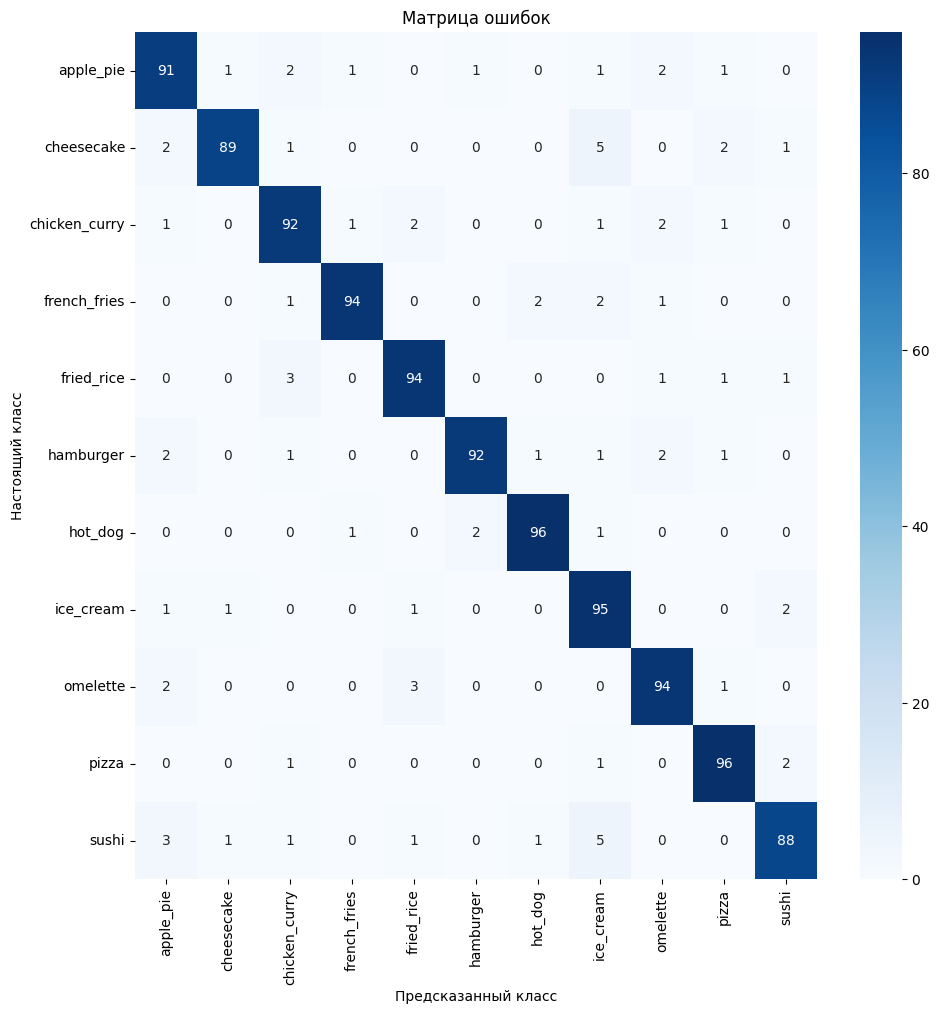

In [22]:
plot_confusion_matrix(model=model_b2, dataloader= test_loader, class_names=test_dataset.classes )

### ***About EfficientNet-B2***
#### **Метрики**
- **train loss=** ***0.2257*** vs **test loss=** ***0.2444***
- **train f1=** ***0.9339*** vs **test f1=** ***0.9283***
- ***model training time: 33:20***

#### **Confusion Matrix Analytics**

- **apple_pie**: 2 раза модель предсказала **chicken_curry**.  
- **apple_pie**: 2 раза модель предсказала **omelette**.  
- **cheesecake**: 5 раз модель предсказала **ice_cream**.  
- **cheesecake**: 2 раза модель предсказала **apple_pie**.  
- **cheesecake**: 2 раза модель предсказала **pizza**.  
- **chicken_curry**: 2 раза модель предсказала **fried_rice**.  
- **chicken_curry**: 2 раза модель предсказала **omelette**.  
- **french_fries**: 2 раза модель предсказала **hot_dog**.  
- **french_fries**: 2 раза модель предсказала **ice_cream**.  
- **fried_rice**: 3 раз модель предсказала **chicken_curry**.  
- **hamburger**: 2 раза модель предсказала **apple_pie**.  
- **hamburger**: 2 раза модель предсказала **omelette**.  
- **hot_dog**: 2 раза модель предсказала **hamburger**.  
- **ice_cream**: 2 раза модель предсказала **sushi**.  
- **omelette**: 3 раз модель предсказала **fried_rice**.  
- **omelette**: 2 раза модель предсказала **apple_pie**.  
- **pizza**: 2 раза модель предсказала **sushi**.  
- **sushi**: 5 раз модель предсказала **ice_cream**.  
- **sushi**: 3 раз модель предсказала **apple_pie**.  


# ***EfficientNet-B3***

In [23]:
weights = EfficientNet_B3_Weights.DEFAULT
model_b3 = efficientnet_b3(weights=weights)
model_b3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.4, inplace=True),
    torch.nn.Linear(in_features=1536, out_features=num_classes)  
)
model_b3 = model_b3.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 141MB/s] 


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_b3.parameters(), lr=1e-4)
num_epochs=15

In [25]:
img_size = 300
batch_size = 16
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(img_size + 20),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(f"{data_dir}/train", transform=train_transforms)
test_dataset  = datasets.ImageFolder(f"{data_dir}/test",  transform=test_transforms)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


In [26]:
train_model(model=model_b3,  train_loader=train_loader,
    test_loader=test_loader,
    train_dataset=train_dataset,
    num_epochs=num_epochs,
    num_classes=num_classes,      
    optimizer=optimizer,
    criterion=criterion,
    device=device,
           )

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/kulikovka/CNN-models-test/e/CNNMOD-30


Epoch 1/15: 100%|██████████| 619/619 [04:46<00:00,  2.16it/s, loss=0.868, acc=71.2%]


Epoch 1: Train loss=1.0072, Acc=0.7121, F1=0.7123 | Test loss=0.3221, Acc=0.9155, F1=0.9158


Epoch 2/15: 100%|██████████| 619/619 [04:49<00:00,  2.14it/s, loss=0.727, acc=86.6%] 


Epoch 2: Train loss=0.4419, Acc=0.8665, F1=0.8665 | Test loss=0.2553, Acc=0.9236, F1=0.9243


Epoch 3/15: 100%|██████████| 619/619 [04:50<00:00,  2.13it/s, loss=0.267, acc=90.0%] 


Epoch 3: Train loss=0.3208, Acc=0.8998, F1=0.8998 | Test loss=0.2171, Acc=0.9382, F1=0.9383


Epoch 4/15: 100%|██████████| 619/619 [04:51<00:00,  2.13it/s, loss=0.457, acc=92.5%] 


Epoch 4: Train loss=0.2449, Acc=0.9253, F1=0.9252 | Test loss=0.2238, Acc=0.9309, F1=0.9311


Epoch 5/15: 100%|██████████| 619/619 [04:54<00:00,  2.10it/s, loss=0.119, acc=93.4%] 


Epoch 5: Train loss=0.2114, Acc=0.9341, F1=0.9341 | Test loss=0.2124, Acc=0.9391, F1=0.9390


Epoch 6/15: 100%|██████████| 619/619 [04:58<00:00,  2.08it/s, loss=0.258, acc=94.8%]  


Epoch 6: Train loss=0.1709, Acc=0.9483, F1=0.9483 | Test loss=0.2154, Acc=0.9327, F1=0.9328


Epoch 7/15: 100%|██████████| 619/619 [05:02<00:00,  2.05it/s, loss=0.0293, acc=95.6%] 


Epoch 7: Train loss=0.1408, Acc=0.9557, F1=0.9556 | Test loss=0.2149, Acc=0.9318, F1=0.9318


Epoch 8/15: 100%|██████████| 619/619 [04:58<00:00,  2.07it/s, loss=0.0118, acc=96.1%] 


Epoch 8: Train loss=0.1313, Acc=0.9611, F1=0.9611 | Test loss=0.2006, Acc=0.9364, F1=0.9365


Epoch 9/15: 100%|██████████| 619/619 [04:58<00:00,  2.08it/s, loss=0.122, acc=96.4%]  


Epoch 9: Train loss=0.1123, Acc=0.9636, F1=0.9636 | Test loss=0.2121, Acc=0.9409, F1=0.9410


Epoch 10/15: 100%|██████████| 619/619 [04:58<00:00,  2.07it/s, loss=0.247, acc=97.0%]  


Epoch 10: Train loss=0.0993, Acc=0.9696, F1=0.9696 | Test loss=0.2281, Acc=0.9355, F1=0.9356


Epoch 11/15: 100%|██████████| 619/619 [04:59<00:00,  2.07it/s, loss=0.48, acc=97.1%]    


Epoch 11: Train loss=0.0918, Acc=0.9706, F1=0.9706 | Test loss=0.2368, Acc=0.9318, F1=0.9321


Epoch 12/15: 100%|██████████| 619/619 [04:58<00:00,  2.07it/s, loss=0.00831, acc=97.3%] 


Epoch 12: Train loss=0.0799, Acc=0.9732, F1=0.9732 | Test loss=0.2495, Acc=0.9291, F1=0.9291


Epoch 13/15: 100%|██████████| 619/619 [04:57<00:00,  2.08it/s, loss=0.00582, acc=97.9%] 


Epoch 13: Train loss=0.0650, Acc=0.9786, F1=0.9786 | Test loss=0.2359, Acc=0.9336, F1=0.9335


Epoch 14/15: 100%|██████████| 619/619 [04:59<00:00,  2.07it/s, loss=0.072, acc=98.0%]   


Epoch 14: Train loss=0.0651, Acc=0.9800, F1=0.9800 | Test loss=0.2855, Acc=0.9309, F1=0.9310


Epoch 15/15: 100%|██████████| 619/619 [04:59<00:00,  2.07it/s, loss=0.00225, acc=98.3%] 


Epoch 15: Train loss=0.0575, Acc=0.9825, F1=0.9825 | Test loss=0.2646, Acc=0.9373, F1=0.9372
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 7 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 7 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/kulikovka/CNN-models-test/e/CNNMOD-30/metadata


{'train_loss': [1.0072386893840752,
  0.44191010006148407,
  0.32084395283099376,
  0.2449284544511877,
  0.21136052272988087,
  0.17089585840702057,
  0.14083811646421449,
  0.1313354958383122,
  0.11233903766129956,
  0.09926454732909498,
  0.09178056013855067,
  0.07989238575279638,
  0.06495949262659056,
  0.06508641640241775,
  0.05754100750313338],
 'train_acc': [0.7121212482452393,
  0.8664646148681641,
  0.8997979760169983,
  0.9252525568008423,
  0.9341414570808411,
  0.9482828378677368,
  0.9556565880775452,
  0.9611111879348755,
  0.9636363983154297,
  0.9695959091186523,
  0.9706060886383057,
  0.9732322692871094,
  0.9785858392715454,
  0.9799999594688416,
  0.9825252294540405],
 'train_f1': [0.712289571762085,
  0.8664520978927612,
  0.8998445272445679,
  0.9252287149429321,
  0.9341104626655579,
  0.9482791423797607,
  0.9556463956832886,
  0.961112380027771,
  0.9636155366897583,
  0.969579815864563,
  0.9706078171730042,
  0.9732312560081482,
  0.9785746335983276,
  0.

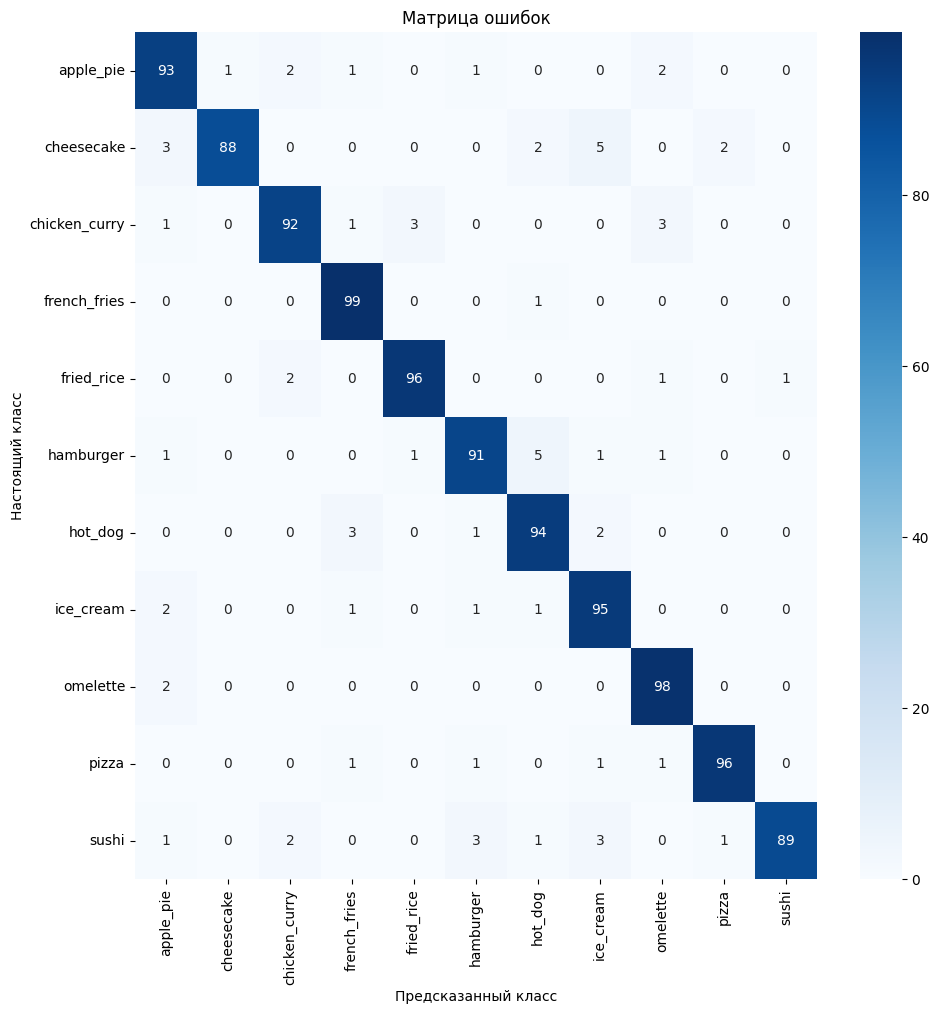

In [27]:
plot_confusion_matrix(model=model_b3, dataloader= test_loader, class_names=test_dataset.classes )

### ***About EfficientNet-B3***
#### **Метрики**
- **train loss=** ***0.0575*** vs **test loss=** ***0.2746***
- **train f1=** ***0.9825*** vs **test f1=** ***0.9372***
- ***model training time: 1:17:08*** *(15 epochs)*

#### **Confusion Matrix Analytics**

- **apple_pie**: 2 раза модель предсказала **chicken_curry**.  
- **apple_pie**: 2 раза модель предсказала **omelette**.  
- **cheesecake**: 5 раз модель предсказала **ice_cream**.  
- **cheesecake**: 3 раз модель предсказала **apple_pie**.  
- **cheesecake**: 2 раза модель предсказала **hot_dog**.  
- **cheesecake**: 2 раза модель предсказала **pizza**.  
- **chicken_curry**: 3 раз модель предсказала **fried_rice**.  
- **chicken_curry**: 3 раз модель предсказала **omelette**.  
- **fried_rice**: 2 раза модель предсказала **chicken_curry**.  
- **hamburger**: 5 раз модель предсказала **hot_dog**.  
- **hot_dog**: 3 раз модель предсказала **french_fries**.  
- **hot_dog**: 2 раза модель предсказала **ice_cream**.  
- **ice_cream**: 2 раза модель предсказала **apple_pie**.  
- **omelette**: 2 раза модель предсказала **apple_pie**.  
- **sushi**: 3 раз модель предсказала **hamburger**.  
- **sushi**: 3 раз модель предсказала **ice_cream**.  
- **sushi**: 2 раза модель предсказала **chicken_curry**.  


# ***MobileNetV2***

In [28]:
weights = MobileNet_V2_Weights.DEFAULT  
model_mobilenetv2 = mobilenet_v2(weights=weights)
model_mobilenetv2.classifier[1] = nn.Linear(model_mobilenetv2.classifier[1].in_features,num_classes)
model_mobilenetv2=model_mobilenetv2.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 118MB/s] 


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mobilenetv2.parameters(), lr=1e-4)
num_epochs=10

In [30]:
img_size = 224
batch_size =32 
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(img_size + 20),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(f"{data_dir}/train", transform=train_transforms)
test_dataset  = datasets.ImageFolder(f"{data_dir}/test",  transform=test_transforms)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


In [31]:
train_model(model=model_mobilenetv2,  
    train_loader=train_loader,
    test_loader=test_loader,
    train_dataset=train_dataset,
    num_epochs=num_epochs,
    num_classes=num_classes,      
    optimizer=optimizer,
    criterion=criterion,
    device=device,
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/kulikovka/CNN-models-test/e/CNNMOD-31


Epoch 1/10: 100%|██████████| 310/310 [01:52<00:00,  2.76it/s, loss=0.968, acc=60.7%]


Epoch 1: Train loss=1.3623, Acc=0.6074, F1=0.6031 | Test loss=0.6175, Acc=0.8191, F1=0.8196


Epoch 2/10: 100%|██████████| 310/310 [01:51<00:00,  2.78it/s, loss=0.368, acc=80.5%]


Epoch 2: Train loss=0.6374, Acc=0.8046, F1=0.8043 | Test loss=0.4432, Acc=0.8691, F1=0.8695


Epoch 3/10: 100%|██████████| 310/310 [01:51<00:00,  2.78it/s, loss=0.818, acc=84.3%]


Epoch 3: Train loss=0.5013, Acc=0.8429, F1=0.8430 | Test loss=0.3934, Acc=0.8791, F1=0.8795


Epoch 4/10: 100%|██████████| 310/310 [01:53<00:00,  2.74it/s, loss=0.723, acc=86.7%]


Epoch 4: Train loss=0.4258, Acc=0.8668, F1=0.8667 | Test loss=0.3647, Acc=0.8855, F1=0.8855


Epoch 5/10: 100%|██████████| 310/310 [01:51<00:00,  2.79it/s, loss=0.945, acc=88.8%] 


Epoch 5: Train loss=0.3614, Acc=0.8881, F1=0.8881 | Test loss=0.3420, Acc=0.8955, F1=0.8959


Epoch 6/10: 100%|██████████| 310/310 [01:50<00:00,  2.80it/s, loss=0.745, acc=89.7%] 


Epoch 6: Train loss=0.3255, Acc=0.8973, F1=0.8973 | Test loss=0.3347, Acc=0.9009, F1=0.9011


Epoch 7/10: 100%|██████████| 310/310 [01:51<00:00,  2.77it/s, loss=0.294, acc=91.6%] 


Epoch 7: Train loss=0.2764, Acc=0.9158, F1=0.9158 | Test loss=0.3258, Acc=0.8955, F1=0.8957


Epoch 8/10: 100%|██████████| 310/310 [01:55<00:00,  2.68it/s, loss=0.356, acc=92.1%] 


Epoch 8: Train loss=0.2528, Acc=0.9213, F1=0.9213 | Test loss=0.3302, Acc=0.8927, F1=0.8930


Epoch 9/10: 100%|██████████| 310/310 [01:55<00:00,  2.68it/s, loss=0.547, acc=92.6%] 


Epoch 9: Train loss=0.2298, Acc=0.9258, F1=0.9258 | Test loss=0.3315, Acc=0.8982, F1=0.8983


Epoch 10/10: 100%|██████████| 310/310 [01:53<00:00,  2.74it/s, loss=0.105, acc=93.6%] 


Epoch 10: Train loss=0.2079, Acc=0.9363, F1=0.9362 | Test loss=0.3241, Acc=0.8991, F1=0.8993
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 7 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 7 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/kulikovka/CNN-models-test/e/CNNMOD-31/metadata


{'train_loss': [1.3622627708406159,
  0.6374368522986017,
  0.5013369911126416,
  0.4258284768672905,
  0.3614039635899091,
  0.3254680260744962,
  0.2763811150704972,
  0.25277355728727396,
  0.22977086999801674,
  0.2079038475017355],
 'train_acc': [0.6073737144470215,
  0.8046464920043945,
  0.8429292440414429,
  0.8667676448822021,
  0.8880807161331177,
  0.8972727060317993,
  0.9157575368881226,
  0.9213131070137024,
  0.9257575273513794,
  0.9362626075744629],
 'train_f1': [0.6031477451324463,
  0.8042979836463928,
  0.8430104851722717,
  0.8667274117469788,
  0.8881053924560547,
  0.8972945213317871,
  0.9157626628875732,
  0.9212849736213684,
  0.9257693290710449,
  0.9362296462059021],
 'test_loss': [0.6175444674491882,
  0.44317870497703554,
  0.39343779466368933,
  0.36471987935629757,
  0.34197987220504067,
  0.3346517906947569,
  0.32576460404829544,
  0.3302399626916105,
  0.3315206090970473,
  0.3240891825340011],
 'test_acc': [0.8190909624099731,
  0.8690909147262573,
 

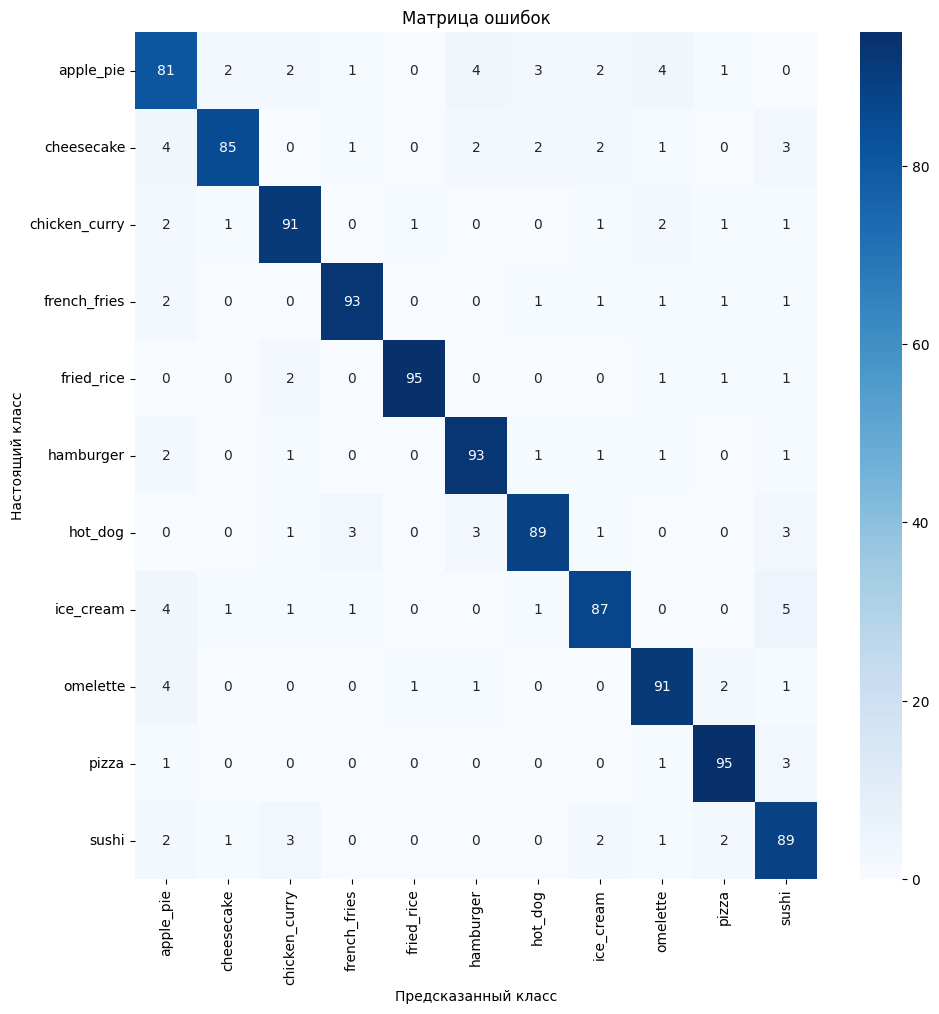

In [32]:
plot_confusion_matrix(model=model_mobilenetv2, dataloader= test_loader, class_names=test_dataset.classes )

### ***About MobileNetV2***
#### **Метрики**
- **train loss=** ***0.2079*** vs **test loss=** ***0.3240***
- **train f1=** ***0.9362*** vs **test f1=** ***0.8993***
- ***model training time: 19:54*** 

#### **Confusion Matrix Analytics**

- **apple_pie**: 4 раз модель предсказала **hamburger**.  
- **apple_pie**: 4 раз модель предсказала **omelette**.  
- **apple_pie**: 3 раз модель предсказала **hot_dog**.  
- **apple_pie**: 2 раза модель предсказала **cheesecake**.  
- **apple_pie**: 2 раза модель предсказала **chicken_curry**.  
- **apple_pie**: 2 раза модель предсказала **ice_cream**.  
- **cheesecake**: 4 раз модель предсказала **apple_pie**.  
- **cheesecake**: 3 раз модель предсказала **sushi**.  
- **cheesecake**: 2 раза модель предсказала **hamburger**.  
- **cheesecake**: 2 раза модель предсказала **hot_dog**.  
- **cheesecake**: 2 раза модель предсказала **ice_cream**.  
- **chicken_curry**: 2 раза модель предсказала **apple_pie**.  
- **chicken_curry**: 2 раза модель предсказала **omelette**.  
- **french_fries**: 2 раза модель предсказала **apple_pie**.  
- **fried_rice**: 2 раза модель предсказала **chicken_curry**.  
- **hamburger**: 2 раза модель предсказала **apple_pie**.  
- **hot_dog**: 3 раз модель предсказала **french_fries**.  
- **hot_dog**: 3 раз модель предсказала **hamburger**.  
- **hot_dog**: 3 раз модель предсказала **sushi**.  
- **ice_cream**: 5 раз модель предсказала **sushi**.  
- **ice_cream**: 4 раз модель предсказала **apple_pie**.  
- **omelette**: 4 раз модель предсказала **apple_pie**.  
- **omelette**: 2 раза модель предсказала **pizza**.  
- **pizza**: 3 раз модель предсказала **sushi**.  
- **sushi**: 3 раз модель предсказала **chicken_curry**.  
- **sushi**: 2 раза модель предсказала **apple_pie**.  
- **sushi**: 2 раза модель предсказала **ice_cream**.  
- **sushi**: 2 раза модель предсказала **pizza**.  


# ***ResNet18***

In [33]:
weights = ResNet18_Weights.DEFAULT
model_resnet18 = resnet18(weights=weights)
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, num_classes)
model_resnet18=model_resnet18.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s] 


In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters(), lr=2e-5)
num_epochs=10

In [35]:
img_size = 224
batch_size = 32 
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(img_size + 20),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(f"{data_dir}/train", transform=train_transforms)
test_dataset  = datasets.ImageFolder(f"{data_dir}/test",  transform=test_transforms)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


In [36]:
train_model(model=model_resnet18,  
    train_loader=train_loader,
    test_loader=test_loader,
    train_dataset=train_dataset,
    num_epochs=num_epochs,
    num_classes=num_classes,      
    optimizer=optimizer,
    criterion=criterion,
    device=device,
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/kulikovka/CNN-models-test/e/CNNMOD-32


Epoch 1/10: 100%|██████████| 310/310 [01:45<00:00,  2.95it/s, loss=0.751, acc=57.6%]


Epoch 1: Train loss=1.4020, Acc=0.5762, F1=0.5765 | Test loss=0.7707, Acc=0.7782, F1=0.7773


Epoch 2/10: 100%|██████████| 310/310 [01:45<00:00,  2.94it/s, loss=0.634, acc=76.0%]


Epoch 2: Train loss=0.7855, Acc=0.7602, F1=0.7601 | Test loss=0.5719, Acc=0.8345, F1=0.8355


Epoch 3/10: 100%|██████████| 310/310 [01:44<00:00,  2.95it/s, loss=0.735, acc=80.5%]


Epoch 3: Train loss=0.6373, Acc=0.8055, F1=0.8055 | Test loss=0.4959, Acc=0.8445, F1=0.8453


Epoch 4/10: 100%|██████████| 310/310 [01:43<00:00,  3.00it/s, loss=0.498, acc=83.2%]


Epoch 4: Train loss=0.5455, Acc=0.8322, F1=0.8324 | Test loss=0.4518, Acc=0.8636, F1=0.8631


Epoch 5/10: 100%|██████████| 310/310 [01:43<00:00,  3.00it/s, loss=0.309, acc=85.2%]


Epoch 5: Train loss=0.4824, Acc=0.8524, F1=0.8525 | Test loss=0.4316, Acc=0.8700, F1=0.8701


Epoch 6/10: 100%|██████████| 310/310 [01:44<00:00,  2.98it/s, loss=0.653, acc=86.1%]


Epoch 6: Train loss=0.4457, Acc=0.8614, F1=0.8614 | Test loss=0.4069, Acc=0.8718, F1=0.8718


Epoch 7/10: 100%|██████████| 310/310 [01:43<00:00,  2.98it/s, loss=0.37, acc=87.5%] 


Epoch 7: Train loss=0.4135, Acc=0.8746, F1=0.8747 | Test loss=0.3960, Acc=0.8791, F1=0.8790


Epoch 8/10: 100%|██████████| 310/310 [01:45<00:00,  2.94it/s, loss=0.473, acc=89.0%]


Epoch 8: Train loss=0.3682, Acc=0.8898, F1=0.8898 | Test loss=0.3831, Acc=0.8800, F1=0.8806


Epoch 9/10: 100%|██████████| 310/310 [01:45<00:00,  2.92it/s, loss=0.563, acc=89.6%]


Epoch 9: Train loss=0.3452, Acc=0.8956, F1=0.8955 | Test loss=0.3774, Acc=0.8891, F1=0.8896


Epoch 10/10: 100%|██████████| 310/310 [01:44<00:00,  2.95it/s, loss=0.311, acc=90.5%] 


Epoch 10: Train loss=0.3105, Acc=0.9049, F1=0.9050 | Test loss=0.3766, Acc=0.8864, F1=0.8861
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 7 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 7 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/kulikovka/CNN-models-test/e/CNNMOD-32/metadata


{'train_loss': [1.4019554146853361,
  0.7854674688252535,
  0.6373104500770569,
  0.545519385385995,
  0.48241296030054187,
  0.4457242432025948,
  0.4135292420844839,
  0.36822874017436097,
  0.3451680141506773,
  0.3105212110822851],
 'train_acc': [0.5761616230010986,
  0.7602020502090454,
  0.8054545521736145,
  0.8322222232818604,
  0.8524242639541626,
  0.8614140748977661,
  0.8746464252471924,
  0.8897979855537415,
  0.8955555558204651,
  0.9049495458602905],
 'train_f1': [0.5765383243560791,
  0.7600523829460144,
  0.8055068254470825,
  0.8323945999145508,
  0.8524999618530273,
  0.8614288568496704,
  0.8747382164001465,
  0.8898067474365234,
  0.895538866519928,
  0.9049902558326721],
 'test_loss': [0.7707218699021773,
  0.5718505035747181,
  0.4958749514276331,
  0.4517767701365731,
  0.4315805573896928,
  0.4068929215994748,
  0.39601843931458214,
  0.3831298660148274,
  0.37740354798056863,
  0.37657636604525824],
 'test_acc': [0.778181791305542,
  0.8345454335212708,
  0.84

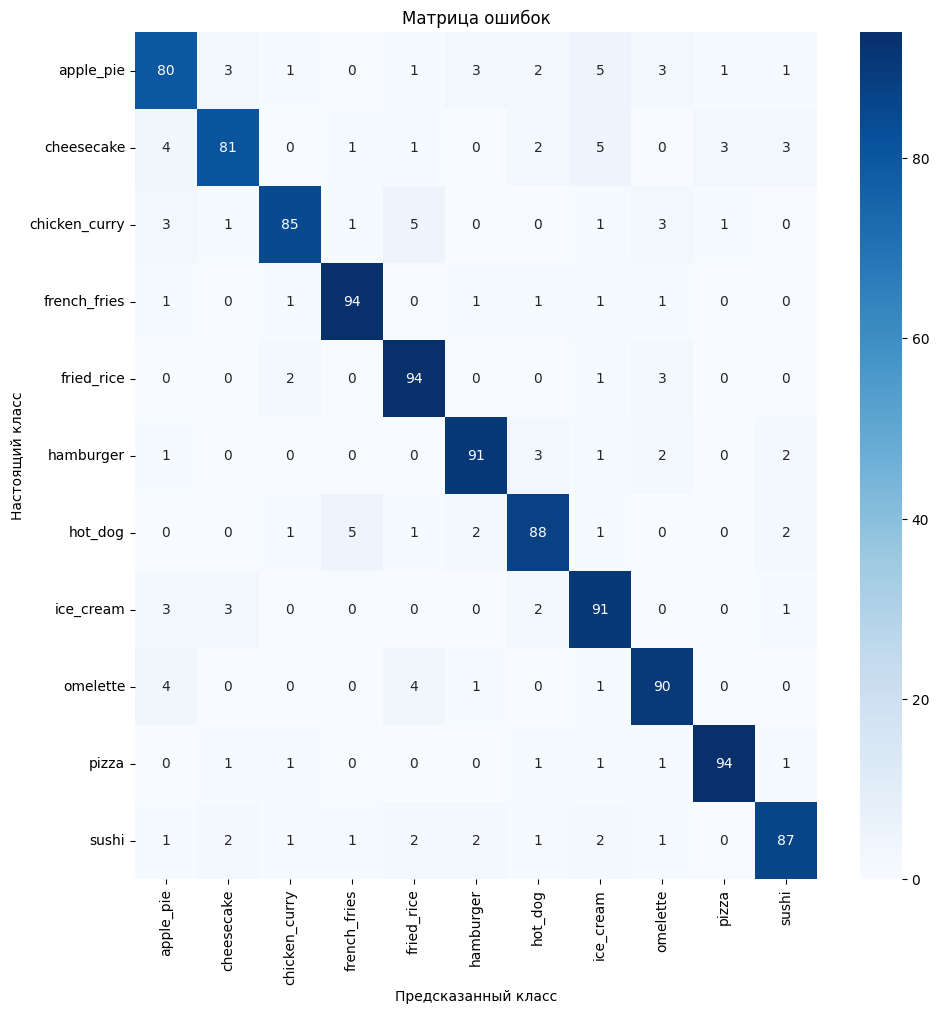

In [37]:
plot_confusion_matrix(model=model_resnet18, dataloader= test_loader, class_names=test_dataset.classes )

### ***About ResNet-18***
#### **Метрики**
- **train loss=** ***0.3105*** vs **test loss=** ***0.3765***
- **train f1=** ***0.9049*** vs **test f1=** ***0.8861***
- ***model training time: 18:32*** 

#### **Confusion Matrix Analytics**

- **apple_pie**: 5 раз модель предсказала **ice_cream**.  
- **apple_pie**: 3 раз модель предсказала **cheesecake**.  
- **apple_pie**: 3 раз модель предсказала **hamburger**.  
- **apple_pie**: 3 раз модель предсказала **omelette**.  
- **apple_pie**: 2 раза модель предсказала **hot_dog**.  
- **cheesecake**: 5 раз модель предсказала **ice_cream**.  
- **cheesecake**: 4 раз модель предсказала **apple_pie**.  
- **cheesecake**: 3 раз модель предсказала **pizza**.  
- **cheesecake**: 3 раз модель предсказала **sushi**.  
- **cheesecake**: 2 раза модель предсказала **hot_dog**.  
- **chicken_curry**: 5 раз модель предсказала **fried_rice**.  
- **chicken_curry**: 3 раз модель предсказала **apple_pie**.  
- **chicken_curry**: 3 раз модель предсказала **omelette**.  
- **fried_rice**: 3 раз модель предсказала **omelette**.  
- **fried_rice**: 2 раза модель предсказала **chicken_curry**.  
- **hamburger**: 3 раз модель предсказала **hot_dog**.  
- **hamburger**: 2 раза модель предсказала **omelette**.  
- **hamburger**: 2 раза модель предсказала **sushi**.  
- **hot_dog**: 5 раз модель предсказала **french_fries**.  
- **hot_dog**: 2 раза модель предсказала **hamburger**.  
- **hot_dog**: 2 раза модель предсказала **sushi**.  
- **ice_cream**: 3 раз модель предсказала **apple_pie**.  
- **ice_cream**: 3 раз модель предсказала **cheesecake**.  
- **ice_cream**: 2 раза модель предсказала **hot_dog**.  
- **omelette**: 4 раз модель предсказала **apple_pie**.  
- **omelette**: 4 раз модель предсказала **fried_rice**.  
- **sushi**: 2 раза модель предсказала **cheesecake**.  
- **sushi**: 2 раза модель предсказала **fried_rice**.  
- **sushi**: 2 раза модель предсказала **hamburger**.  
- **sushi**: 2 раза модель предсказала **ice_cream**.  


# ***General Analytics***

#### **Общие метрики производительности на тесте**

| Модель           | Test F1     | Test Loss   | Train/Test F1 diff | Время обучения |
|------------------|-------------|-------------|-----------------|----------------|
| **EfficientNet-B0** | 0.9147      | 0.3035      | +0.0261         | 22:20          |
| **EfficientNet-B1** | 0.9230      | 0.2512      | +0.0058         | 27:32          |
| **EfficientNet-B2** | 0.9283      | 0.2444      | +0.0056         | 33:20          |
| **EfficientNet-B3** | 0.9372      | 0.2746      | +0.0453         | 1:17:08        |
| **MobileNetV2**     | 0.8993      | 0.3240      | +0.0369         | 19:54          |
| **ResNet-18**       | 0.8861      | 0.3765      | +0.0188         | 18:32          |


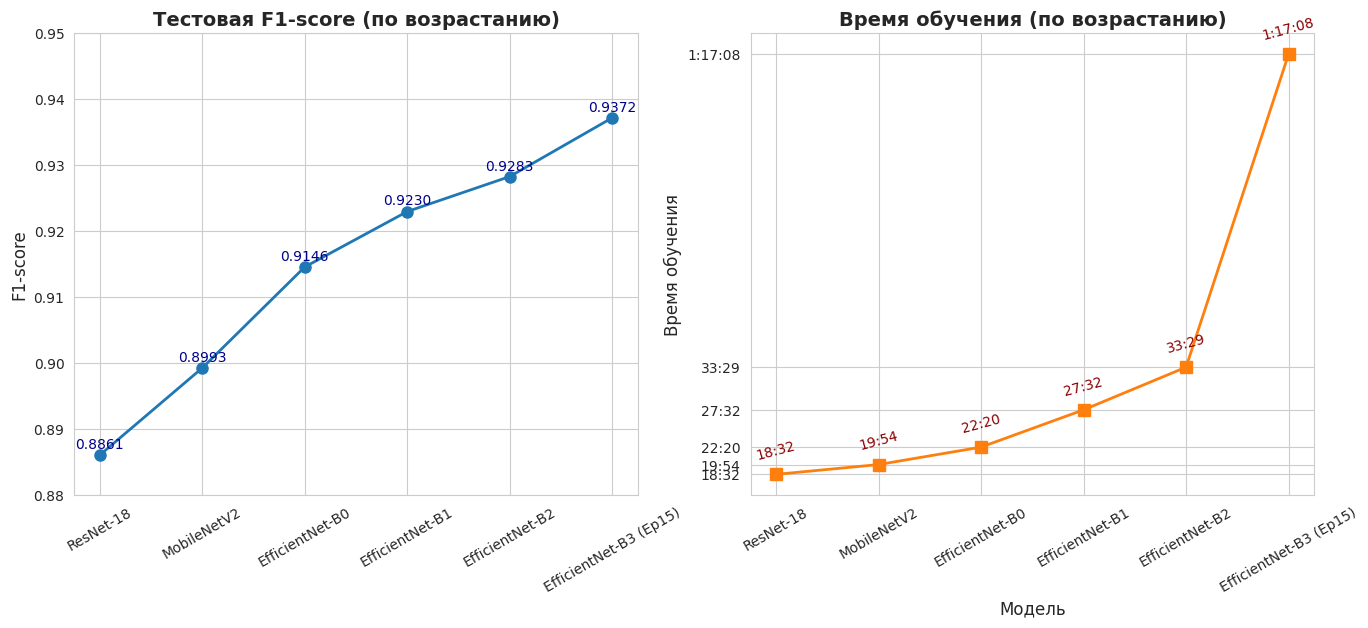

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

models = [
    "EfficientNet-B0",
    "EfficientNet-B1",
    "EfficientNet-B2",
    "EfficientNet-B3 (Ep15)",
    "MobileNetV2",
    "ResNet-18"
]

test_f1 = [0.9146, 0.9230, 0.9283, 0.9372, 0.8993, 0.8861]
train_time_str = ["22:20", "27:32", "33:29", "1:17:08", "19:54", "18:32"]

def time_to_seconds(t):
    parts = list(map(int, t.split(':')))
    if len(parts) == 2:
        return parts[0] * 60 + parts[1]
    else:
        return parts[0] * 3600 + parts[1] * 60 + parts[2]

f1_data = sorted(zip(models, test_f1), key=lambda x: x[1])
models_f1_sorted, f1_sorted = zip(*f1_data)

time_seconds = [time_to_seconds(t) for t in train_time_str]
time_data = sorted(zip(models, train_time_str, time_seconds), key=lambda x: x[2])
models_time_sorted, time_str_sorted, time_sec_sorted = zip(*time_data)

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(models_f1_sorted, f1_sorted, marker='o', linewidth=2, markersize=8, color='#1f77b4')
ax1.set_title('Тестовая F1-score (по возрастанию)', fontsize=14, fontweight='bold')
ax1.set_ylabel('F1-score', fontsize=12)
ax1.set_ylim(0.88, 0.95)
ax1.tick_params(axis='x', rotation=30)
for i, val in enumerate(f1_sorted):
    ax1.text(i, val + 0.001, f'{val:.4f}', ha='center', fontsize=10, color='darkblue')

ax2.plot(models_time_sorted, time_sec_sorted, marker='s', linewidth=2, markersize=8, color='#ff7f0e')
ax2.set_title('Время обучения (по возрастанию)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Время обучения', fontsize=12)
ax2.set_xlabel('Модель', fontsize=12)
ax2.tick_params(axis='x', rotation=30)

ax2.set_yticks(time_sec_sorted)
ax2.set_yticklabels(time_str_sorted)

for i, (t_sec, t_str) in enumerate(zip(time_sec_sorted, time_str_sorted)):
    ax2.text(i, t_sec + 100, t_str, ha='center', va='bottom', fontsize=10, color='darkred', rotation=15)
